In [1]:
%matplotlib inline
%run 'MonteCarlo.py'
import matplotlib.pyplot as plt

# Classical Monte Carlo of $S_N$ Model on Hypertree Lattice

## Statistical Mechanics

### Generic Model
The most general StatMech model we consider is specified by the following ingredients:
* **Lattice**: we will only consider *bipartite* lattice, on which the block Gibbs sampling can be carried out.
 * The bipartite lattice contains two **sublattices** labeled by *A* and *B*.
 * The **boundary**, labeled by *C*, refers to the sites that will not be updated in Monte Carlo. The boundary configuration is fixed by the boundary condition and will not be updated. 
* **Group**: on each site, the degree of freedom is a permutation group element $g_i\in S_n$, which we will called the "spin" hereinafter.
 * Each spin state will be represented as a vector in the canonical representation of $S_n$. For example, for $S_2$ group: $|()\rangle=(1,0)^\intercal$, $|(12)\rangle=(0,1)^\intercal.$
* **Action**:
$$S[g] = -\sum_{\langle ij\rangle} K_{ij}\chi(g_i,g_j),$$
where $\chi(g_i,g_j)=\text{Tr}g_i^{-1}g_j$ is the group character (the number of cycles). The partition function is given by
$$Z = -\sum_{[g|A\cup B]}e^{-S[g]} = e^{-F[g|C]}.$$
With given boundary, the free energy $F$ is a function of the boundary configuration.

### Monte Carlo Algorithm

#### Update Algorithms
The basic idea of importance sampling is to set up a suitable Markov chain that draws configurations according to the Boltzmann weight
$$P[g] = \frac{e^{-S[g]}}{Z}.$$
There are two classes of update schemes:
* Local update algorithms (Metropolis, **Heat-Bath**)
* Cluster update algorithms (Swendsen-Wang Cluster, Wolff Cluster)

#### Local Update
The cluster update greately reduces the dynamic scaling at the critical point, which speed up the convergence in the critical region. Cluster update works well for Potts model, where the spins interacts via delta function: such that the domain wall between all different spins are of the same tension (energy). In the Wolff cluster algorithm, a site is first choosen, and neighboring sites of the same spin can attach to the cluster with probability $p$ (sites of different spins should not attach), and finally the whole cluster is flipped. The transition rate can satisfy the detail balance because the intereial weight is the same ($=p^{C-1}$ where $C$ is number of cluster site, this is because the cluster is grown following a tree, and all trees are equivalent in bond number if the site number is fixed), so the only difference is on the boundary. There are two types of cluster boundaries: boudaries between different spins (of tension 0) and boundary between same spins (of tension $-\ln p$). After flipping, the two types of boundary will switch their positions, so it can match the detail balance condition. More precisely, the partition function for $n$-state Potts model can be cast into
$$Z\propto\sum_{\text{config}}p^{\text{#link}}n^{\text{#cluster}}.$$
This is due to the nice delta function structure. However for our $S_n$ model, the delta interaction is soften in some sense. Then the partition function no longer has the nice link and cluster structure, which make it hard to do cluster update.

While it remains a question of <font color='red'>how to design a cluster update algorithm for $S_n$ model</font>, we will try the local update first, in particular the heat-bath update. The current code uses **block Gibbs sampling** + **heat-bath update**, alternatively sampling on A and B sublattices.

### Statistical Analysis

#### Estimate Autocorrelation Time

The time series generated by Monte Carlo simulation are *correlated*. We will mainly consider the autocorrelation in *energy density fluctuations* $$C(t_1,t_2)=\langle e(t_1) e(t_2)\rangle-\langle e(t_1)\rangle\langle e(t_2)\rangle$$ (each time step is an update of the entire system). The autocorrelation typically decays exponentially $C(t)= \sigma_{e}^2 e^{-t/\tau}$, where $\sigma_e^2$ is the variance of the energy density, and $\tau$ is the **autocorrelation time**. It can be estimated from the *binning analysis of time series data*. 

Let $\bar{e}=N^{-1}\sum_t e(t)$ be the average of $e(t)$ in a time series of length $N$. The average itself is a random variable, and has its variance $\sigma_{\bar{e}}^2$.
$$\sigma_{\bar{e}}^2=\langle\bar{e}^2\rangle-\langle\bar{e}\rangle^2=\frac{1}{N^2}\sum_{t_1,t_2}\langle e(t_1)e(t_2)\rangle-\langle e(t_1)\rangle\langle e(t_2)\rangle=\frac{1}{N^2}\sum_{t_1,t_2}C(t_1,t_2).$$
We can think of the correlation function $C(t_1,t_2)$ as an matrix, whose diagonal elements are $\sigma_{e}^2$ (the fluctuation of each single energy in the time series), and the off-diagonal elements decay exponentially with the distance to the diagonal. A finite correlation time $\tau$ means that there are several ($\sim 2\tau$) off-diagonals ($\tau$ to the upper and $\tau$ to the lower) that are of the same order as the diagonal (which is $\sigma_e^2$). The variance of the average energy is nothing by the sum of all elements in the correlation matrix divided by $N^2$. Given the band diagonal structure of the correlation matrix (a band of $N$ diagonals with width $2\tau$), the sum of the correlation matrix is simply $\sum_{t_1,t_2}C(t_1,t_2)=(2\tau)N\sigma_e^2$. Therefore the variance of the average energy density is 
$$\sigma_{\bar{e}}^2=\frac{(2\tau)}{N}\sigma_{e}^2\Rightarrow 2\tau=\frac{N\sigma_{\bar{e}}^2}{\sigma_e^2}.$$
from which the correlation time can be estimated. Now the challenge is to estimate the variance of the average $\bar{e}$. This can be done by binning analysis. The idea is quite straight forward: just take several ($N_B$) bins, and calculate the average for each of them (denoted $e_j^{(B)}$), then calculate the variance of the averages. 
$$\sigma_{\bar{e}}^2=\frac{1}{N_B(N_B-1)}\sum_{j=1:N_B}(e_j^{(B)}-\bar{e})^2$$
Of cause, the size of the bin must be much greater than $\tau$ in order to get an convergent estimation of $\tau$. The bin size can be choosen adaptively, i.e. we start with a relatively small bin size, double the bin size each time (by collecting more samples), until the estimation converges (in the weak sense).

A good a priori estimate is to wait at least about $20\tau$ to reach thermal equilibrim. The correlation time can be very long in the critical region due to critical slowdown. For local update, $\tau\sim L^{z}$ with the dynamical exponent $z=2$.

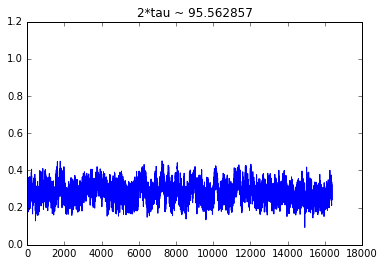

In [3]:
# estimate energy fluctuation autocorrelation time
mdl = LatticeModel(SquareLattice(32,[1.]),Group(2))
mdl.beta = 0.88
tau2, ets, mts = mdl.estimate_tau()
plt.plot(numpy.array(list(range(len(ets)))), ets)
plt.ylim(0,1.2); plt.title('2*tau ~ %f'%tau2)
numpy.save('data/ets',ets)

#### Reweighting Techniques

**How to calculate free energy**?

Let $\Omega(E)$ be the phase space volume (many-body density of state) at energy $E$, then the partition function $Z_{\beta}$ at inverse temperature $\beta$ can be written as follows, which also gives the probability distribution $p_{\beta}(E)$ of the energy,
$$Z_{\beta}=\sum_{E}\Omega(E)e^{-\beta E} \Rightarrow p_{\beta}(E)=\frac{1}{Z_\beta}\Omega(E)e^{-\beta E}.$$
The key idea of **reweighting** is that the phase space volume $\Omega(E)$ is temperature independent, and the temperature dependence are all in the Gibbs weight $e^{-\beta E}$, which can be easily reweighted. Consider
$$\langle e^{-(\beta_2-\beta_1)E}\rangle_{\beta_1}=\sum_{E}e^{-(\beta_2-\beta_1)E}p_{\beta_1}(E)=\sum_{E}\frac{1}{Z_{\beta_1}}\Omega(E)e^{-\beta_2 E}=\frac{Z_{\beta_2}}{Z_{\beta_1}}.$$
So by evaluating the average of **reweighting factor** $e^{-(\beta_2-\beta_1)E}$ over the Monte Carlo samples at $\beta_1$, we can obtain the ratio between partition functions between different temperatures. In this way, a self-consistent solution of free energy over all temperature range can be obtained by sweeping back and forth to update the partition function.

## Code Structure
Objects:
* **Group**
* **Lattice** (SquareLattice, HypertreeLattice)
* **Model** (LatticeModel)
    * Wrapper of the FORTRAN extension MC (provides interface for data transfer and control).

### `Group` Object

**`Group(n)`** represents a permutation group $S_n$.
- Each element is a tuple of $n$ numbers, representing the permutation of $(0,1,...,n-1)$.

#### Attributes
- `Group.dof` gives the order of the group, i.e. $n!$, which is also the degrees of freedom on each site.
- `Group.chi` the table of $\chi(g_1,g_2)$ (adjusted by $-n$).
- `Group.element` gives the list of all group elements.
- `Group.index` is a dictionary that maps group element to its index.

After initialization, `Group.dof` and `Group.chi` should have been set.

#### Methods

In [2]:
'''multiplication table'''
group = Group(3)
[[group.index[group.multiply(g,h)] for h in group] for g in group]

[[0, 1, 2, 3, 4, 5],
 [1, 0, 4, 5, 2, 3],
 [2, 3, 0, 1, 5, 4],
 [3, 2, 5, 4, 0, 1],
 [4, 5, 1, 0, 3, 2],
 [5, 4, 3, 2, 1, 0]]

In [3]:
'''check group inversion'''
[group.index[group.multiply(g, group.inverse(g))] for g in group]

[0, 0, 0, 0, 0, 0]

In [4]:
'''characters'''
{g: group.character(g) for g in group}

{(0, 1, 2): 3,
 (0, 2, 1): 2,
 (1, 0, 2): 2,
 (1, 2, 0): 1,
 (2, 0, 1): 1,
 (2, 1, 0): 2}

The character of a permutation is defined as the number of cycles in the permutation, denoted as $\ln\text{Tr}g$, ranging from $1$ to $n$. Upon initialization, the <code>Group</code> object generates the table of
$$\chi(g_1,g_2)=\ln\text{Tr} g_1 g_2^{-1}-n.$$
One can show that $\chi(g_1,g_2)=\chi(g_2,g_1)$ and $\forall g: \chi(gg_1,gg_2)=\chi(g_1g,g_2g)=\chi(g_1,g_2)$.
* This is the interaction function between two spins across a bond.
* The shift $-n$ is needed to avoid partition weight overflow at low temperature. 

In [5]:
Group(3).chi

[[0, -1, -1, -2, -2, -1],
 [-1, 0, -2, -1, -1, -2],
 [-1, -2, 0, -1, -1, -2],
 [-2, -1, -1, 0, -2, -1],
 [-2, -1, -1, -2, 0, -1],
 [-1, -2, -2, -1, -1, 0]]

### `Lattice` Object

**`Lattice()`** defines a genaric lattice object (bydefault an empty lattice). 

Different types of lattices are realized as **inheritances** of the `Lattice` class:
- `HypertreeLattice(L,Ks,branches)` for hyertree lattice.
- `SquareLattice(L,Ks)` for square lattice.

For the purpose of block-Gibbs update, the lattice should be a **bipartite graph**.
- The **bulk** sites are partitioned to A and B sublattices.
  - The numbers of sites in A and B are denoted as `Lattice.na` and `Lattice.nb`.
  - There is no lattice bond with in the same sublattice.
- The **boundary** sites are ascribed to the C sublattice.
  - The number of boundary sites is `Lattice.nc`
- The total number of sites (including bulk and boundary) is `Lattice.nsite`

**Site Ordering Rules**. The sites are arranged according to the following rules:
- *Bulk sites befor boundary sites*. A, B must come before C.
  - `MC` module because will not allocate state variables for C sites
- *Contineous index* for A and B sites, s.t. within each sublattice dont scatter around.

#### `Site` Subclass

Each inheritance lattice class should contain a definition of the **`Site` subclass** that is specific to the particular type of the hosting lattice (because different lattice may have different coordinate systems and sublattice partition scheme). The `Site` subclass should contain the following
- **Attributes**:
  - `coordinate` a tuple of the coordinate of the site. This attribute is usually set at initialization.
  - `label='A','B','C'` labels the sublattice of the site. This will be set by the method `get_label(lattice)`.
  - `index` keeps the site index in the lattice, will be set by the lattice initialization.
  - One may also introduce attributes for each coordinate component (but that is not required).
- **Methods**:
  - `get_label(lattice)` set the attribute `label` to: `A`,`B` or `C`, and return it. It takes the hosting lattice as its input, such that the global parameters of the lattice can be passed with the entire lattice object.
  - `sortkey()` returns the key for sorting the site.

#### Attributes

There are two groups of attributes:
- Lattice structural attributes
  - `nsite`, `na`, `nb`, `nc`. They must satisfy `na + nb + nc = nsite`.
  - `sites` (site container) is a list of all sites in the lattice (including both bulk and boundary).
  - `coordmap` is a dictionary that maps the coordinates to the site index.
- Action related attributes
  - `irng` a list of length `nsite+1` to specify the partition of `jlst` and `klst`, s.t. the data block for site `i` is specified by the slice `irng[i]:irng[i+1]`.
  - `jlst`, `klst` lists of j-index and corresponding coupling strength K. Both lists are of the length `nlst`.
  
#### Methods

Each inheritance lattice clase must redefine the follwing methods:
- `get_site()` return a list of all lattice sites (no need to be labeled, sorted or indexed, just create objects).
- `Action()` assuming the *lattice has been assembled* (sites labeled, sorted and indexed), return the Action terms as `(i,j,K)` tuples, such that $S=-\frac{1}{2}\sum_{i,j}K_{ij}\chi(g_i,g_j)$ (note the 1/2 factor to correct the double counting.)

#### Hypertree Lattice
- **`HypertreeLattice(L, Ks, branches)`**: creates a hypertree lattice of
  - `L` sites in the ultimate UV layer,
  - Make specific number of `branches` (default = 2) towards IR (which is also the number of sites in each block).
    - For each given depth and feature, the spacial sites are partitions into groups of sizes upto `branches`.
    - Each group develops new features in the deeper IR layer, and the connection is *bipartite complete*.
    - If a group contains only one site, it will not develop new IR features (lattice will terminate in this way).
  - The coupling strengths are provided by `Ks`, as list or as array.
    - `Ks=[K0,K1,K2,...]` are the coupling strengths to each branches.
    - If `Ks` contains *less* couplings then the number of `branches`, unspecified branches will be *decoupled*.
    - If `Ks` contains *more* couplings than the number of `branches`, extra couplings will be *neglected*.
- Sublattice partition convension:
  - A sublattice must contain the **ultimate UV** sites, which are also arranged to the **front**, such that the measurement of these sites can be conviniently specified.
  - C sublattice are the **ultimate IR** site, which are arranged to the **back**.

In [2]:
lattice = HypertreeLattice(6,Ks=[1.,2.,3.],branches=3)
for key in ('nsite','na','nb','nc','nlst','irng','jlst','klst'):
    print(key,':',vars(lattice)[key])
for site in lattice:
    print('%s%s - IR: %s UV: %s'%(site.label,repr(site),repr(site.IR),repr(site.UV)))

nsite : 18
na : 6
nb : 6
nc : 6
nlst : 60
irng : [ 1  3  5  7  9 11 13 18 23 28 33 38 43 46 49 52 55 58 61]
jlst : [ 7  8  7  8  9 10  9 10 11 12 11 12  1  2 13 14 15  1  2 16 17 18  3  4 13
 14 15  3  4 16 17 18  5  6 13 14 15  5  6 16 17 18  7  9 11  7  9 11  7  9
 11  8 10 12  8 10 12  8 10 12]
klst : [ 1.  1.  2.  2.  1.  1.  2.  2.  1.  1.  2.  2.  1.  2.  1.  1.  1.  1.
  2.  1.  1.  1.  1.  2.  2.  2.  2.  1.  2.  2.  2.  2.  1.  2.  3.  3.
  3.  1.  2.  3.  3.  3.  1.  2.  3.  1.  2.  3.  1.  2.  3.  1.  2.  3.
  1.  2.  3.  1.  2.  3.]
A0:<2,0,0> - IR: [] UV: [6:<1,0,0>, 7:<1,0,1>]
A1:<2,1,0> - IR: [] UV: [6:<1,0,0>, 7:<1,0,1>]
A2:<2,2,0> - IR: [] UV: [8:<1,1,0>, 9:<1,1,1>]
A3:<2,3,0> - IR: [] UV: [8:<1,1,0>, 9:<1,1,1>]
A4:<2,4,0> - IR: [] UV: [10:<1,2,0>, 11:<1,2,1>]
A5:<2,5,0> - IR: [] UV: [10:<1,2,0>, 11:<1,2,1>]
B6:<1,0,0> - IR: [0:<2,0,0>, 1:<2,1,0>] UV: [12:<0,0,0>, 13:<0,0,1>, 14:<0,0,2>]
B7:<1,0,1> - IR: [0:<2,0,0>, 1:<2,1,0>] UV: [15:<0,0,3>, 16:<0,0,4>, 17:<0,0,5>]
B

#### Square Lattice
- **`SquareLattice(L, Ks)`**: creates a square lattice of
  - `L` x `L` sites with *periodic* boundary condition along both dimensions.
  - There is only one coupling, uniform through out the lattice, given by `K[0]`.
    - If `Ks` contains more than one couplings, extra couplings will be *neglected*.
    - But it is possible that in future, extra couplings in `Ks` can be assigned to 2nd, 3rd neighbors ect.
- Sublattice partition convension:
  - A = even sublattice, B = odd sublattice. Such a partition requies: **`L` must be even**!
  - There is no boundary sites. So C is empty.

In [96]:
lattice = SquareLattice(4,[1.])
for key in ('nsite','na','nb','nc','nlst','irng','jlst','klst'):
    print(key,':',vars(lattice)[key])
for site in lattice:
    print('%s%s - neighbors: %s'%(site.label,repr(site),repr(site.neighbors)))

nsite : 16
na : 8
nb : 8
nc : 0
nlst : 64
irng : [ 1  5  9 13 17 21 25 29 33 37 41 45 49 53 57 61 65]
jlst : [ 9 10 11 15  9 10 12 16  9 11 12 13 10 11 12 14 11 13 14 15 12 13 14 16  9
 13 15 16 10 14 15 16  1  2  3  7  1  2  4  8  1  3  4  5  2  3  4  6  3  5
  6  7  4  5  6  8  1  5  7  8  2  6  7  8]
klst : [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
A0<0,0> - neighbors: [[14<3,0>, 9<0,3>, 8<0,1>, 10<1,0>]]
A1<0,2> - neighbors: [[15<3,2>, 8<0,1>, 9<0,3>, 11<1,2>]]
A2<1,1> - neighbors: [[8<0,1>, 10<1,0>, 11<1,2>, 12<2,1>]]
A3<1,3> - neighbors: [[9<0,3>, 11<1,2>, 10<1,0>, 13<2,3>]]
A4<2,0> - neighbors: [[10<1,0>, 13<2,3>, 12<2,1>, 14<3,0>]]
A5<2,2> - neighbors: [[11<1,2>, 12<2,1>, 13<2,3>, 15<3,2>]]
A6<3,1> - neighbors: [[12<2,1>, 14<3,0>, 15<3,2>, 8<0,1>]]
A7<3,3> - neig

### `Model` Object

The Monte Carlo samplings are performed by the FORTRAN extension `MC`. The module `MC` contains two parts:
* **`MC.core`**: *CPU* intensive, for MC sampling and register macroscopic observibles.
* **`MC.data`**: *memory* intensive, for data storage and procession.

The `Model` object is a *python interface* for the `MC` module, it has *no physical attributes* (all attributes refers to `MC`). Because all `Model` instances shares the same `MC` kernel, so **there must only one active `Model` object at any time**. More than two active `Model` objects will interefer with each other.

In [2]:
print(MC.__doc__)

This module 'MC' is auto-generated with f2py (version:2).
Functions:
Fortran 90/95 modules:
  core --- dof,nb,jlst,nsite,energy,klst,irng,nc,na,nlst,chi,hist,config,init(),seed(),run(),get_energy(),get_hist(),dump(),load()  data --- energy2,energy1,nspin,monitor,magnet1,spins,magnet2,measure().


#### Attributes

The three-block data structure: system, state and data.
- **`system`**: static, not changed during MC update, defines the system. 
  - The full set of system parameters are specified by the Model class attribute `Model.system_parameters`
  - During the temperature ramping, only `klst` will change. The other parameters are fixed by the lattice graph and on-site group.
- **`state`**: dynamic, updated by MC sampling.
  - Can be kept for future restart of the Markov chain.
- **`data`**: read only, for data collection and read out. `Model` will keep extending the data collected from `MC`.

Mapping the attributes between **MC** (**FORTRAN** module) and **Model** (**python** object):
- The system and state parameters are linked (as inout) between MC and Model.
- The data parameters are output from MC to Model after each measurement.


    MC                                                        Model
    +- MC.core                                   Model.system[:] -+
    |  +- MC.core.dof                 <==>   Model.dof        -+  |
    |  +- MC.core.nsite               <==>   Model.nsite      -+  |
    |  +- MC.core.na                  <==>   Model.na         -+  |
    |  +- MC.core.nb                  <==>   Model.nb         -+  |
    |  +- MC.core.nc                  <==>   Model.nc         -+  |
    |  +- MC.core.nlst                <==>   Model.nlst       -+  |
    |  +- MC.core.chi[:dof,:dof]      <==>   Model.chi        -+  |
    |  +- MC.core.irng[:nsite+1]      <==>   Model.irng       -+  |
    |  +- MC.core.jlst[:nlst]         <==>   Model.jlst       -+  |
    |  +- MC.core.klst[:nlst]         <==>   Model.klst       -+  |
    |  |                                          Model.state[:] -+
    |  +- MC.core.action              <==>   Model.action     -+  |
    |  +- MC.core.beta                <==>   Model.beta       -+  |
    |  +- MC.core.config[:nsite]      <==>   Model.config     -+  |
    |  +- MC.core.hist[:dof]          <==>   Model.hist       -+  |
    +- MC.data                                     Model.data[:] -+
       +- MC.data.nts                ===>    Model.nts        -+
       +- MC.data.ets[:nts]          ===>    Model.ets        -+
       +- Mc.data.mts[:dof,:nts]     ===>    Model.mts        -+

Notes:
- The `Model` attributes *do not physically exist*. They are accessed by `getattr` and `setattr` methods. The system and state attributes can be set as a whole by passing the dictionary. The data attributs are read only, setting `Model.data` will not affect the variables in the MC module.
- `Model` object provides **state parameter parsing**.
  - `action='unknown'`: call `get_action()` to initialize.
  - `beta='default'`: set `beta` = 1.
  - `config='FM','uniform'`: initialize with 0's; `'PM','random'`: initialize with random spins from `range(dof)`.
  - `hist='unknown'`: allocate `hist` and then call `get_hist()` to initialize.
- When attribute getter is called to get `action` and `hist`, it is first checked whether they have been calculated, if not, will evoke MC module (by calling `MC.core.get_action()` or `.get_hist()`) to calculate and then return.
- `MC.core.dump()` and `MC.core.load()` can be called to dump/load core variables.
- `MC.core.seed(x)` seed the random number generator by `x`.

#### Methods

`Model.run(steps)` just runs the MC updates for specific `steps`.

`Model.collect(steps)` collect time series for specific `steps`,
- `Model.nts` increased by the length of time series
- `Model.ets` extended by energy density series: $e=S/(\beta N)$ energy density over all sites including the boundary).
- `Model.mts` extended by magnetization density series: $m=N_{A\cup B}^{-1}\sum_{i\in A\cup B} g_i$ and $g_i$ is represented as a vector in the canonical representation.

#### Core Performance

**Heat-Bath** update: on each site $i$, randomly draw a new spin state $g_i$ (regardless of the previous spin state) with probability:
$$p(g_i)=\frac{e^{h(g_i)}}{\sum_{g'_i}e^{h(g'_i)}}, h(g_i)=\sum_{j \text{n.n.}i}K_{ij}\chi(g_i,g_j).$$

**Block-Gibbs** sampling: spins in the same sublattice are block-updated.
- For A sublattice: `I=1:NA`
- For B sublattice: `I=NA+1:NA+NB`.

FROTRAN implementation (for each spin update):
- `RAND_NUMBER`: initialize `RND` by a random real drawn from the uniform distribution in $[0,1]$. gfortran implements KISS random number generator, $2^{123}$.
- `SET_BLOCK`: sets the cumulated weights and renoralized random real
  - `SET_BIAS`: calculate the on-site bias fields (site indexed by `I`) as `sum(CHI[:,CONFIG[JLST[J]]]*KLST[J] for J in range(IRNG[I],IRNG[I+1]))`. The result is a vector of `DOF` components, which specify the bias field for all group elements.
  - `SET_WEIGHT`: exponentiate the bias fields and accumulate to unormalized CDF weights. The time of this step can vary from 4ns to 10ns depending on the value of the exponent. `EXP(x)` has a quick return for `x=0` but slower for generic `x`. The last compunent is the total partition weight.
  - `RND *= WEIGHT[-1]`: the random real is then multiplied by the total partition weight, such that it is distributed uniformly from 0 to the total weight.
- `CHOOSE`: `WEIGHT` and `RND` is then used to make choice of the new spin state, implemented by a binary serach to determine which bin in `WEIGHT` does `RND` fall into.

In each step (sweep) of MC sampling, the *entire bulk is updated* (which contains two block Gibbs sampling: A-given-B and B-given-A). Measurements are made after the bulk update, so the measurement time is neglegable. For one MC step, the complexity depends on:
- $N$ - the number of bulk sites.
- $n!$ - group order (onsite degrees of freedom).

<table align="left">
<tr><td>procedure</td><td>complexity</td><td>time<sup>1</sup>(ns)</td><td>time<sup>2</sup>(ns)</td></tr>
<tr><td><code>RAND_NUMBER</code></td><td>$N$</td><td>5.0</td><td>13.8</td></tr>
<tr><td><code>SET_BLOCK</code></td><td>~$Nn!$</td><td>8.8</td><td>12.1</td></tr>
<tr><td><code>    SET_BIAS</code></td><td>$Nn!$</td><td>1.3</td><td>2.3</td></tr>
<tr><td><code>    SET_WEIGHT</code></td><td>$Nn!$</td><td>7.5</td><td>9.8</td></tr>
<tr><td><code>        EXP</code></td><td>$Nn!$</td><td>6.7</td><td>8.0</td></tr>
<tr><td><code>    RND</code></td><td>$N$</td><td>2.1</td><td>2.1</td></tr>
<tr><td><code>CHOOSE</code></td><td>$N\log(n!)$</td><td>5.0</td><td>5.6</td></tr>
</table>

Average update time per spin scales with $n$ as:
<table align="left">
<tr><td>$n=$</td><td>2</td><td>3</td><td>4</td><td>5</td><td>6</td></tr>
<tr><td>time<sup>1</sup>(μs)</td><td>0.049</td><td>0.10</td><td>0.27</td><td>1.10</td><td>7.1</td></tr>
<tr><td>time<sup>2</sup>(μs)</td><td>0.056</td><td>0.12</td><td>0.35</td><td>1.52</td><td>9.1</td></tr>
</table>

CPU: 3GHz Intel Core i7. time<sup>1</sup>: *single* precision real (32bit), time<sup>2</sup>: *double* precision real (64bit)

**Profiling** code:

In [3]:
%reload_ext snakeviz
%run 'MonteCarlo.py'
%snakeviz LatticeModel(SquareLattice(100,[0.72]),Group(3)).run(1000,0)

 
*** Profile stats marshalled to file '/var/folders/lt/kgph6qbj6y306pfhbyd1kn2r0000gn/T/tmphhjwo7yx'. 


#### Model Construction

- **`Model(system,state)`** creates a interface of the `MC` module.
  - `system` argument is required, passed in as a dictionary, which must contains all the keys specified in the class variable `Model.system_parameters` (`ValueError` will be raised if any key missing).
  - `state` argument is optional, but can be useful to reload the model and continue the simulation from saved states.
- **`LattticeModel(lattice,group)`** creates a initialized model from `lattice` and `group`, as an inheritance of `Model`.
  - `lattice` is a `Lattice` object and `group` is a `Group` object. They provide the necessary data to build a model.

In [3]:
LatticeModel(HypertreeLattice(4,[1.,0.2]),Group(2))

### `Platform` Object

**`Platform(model)`** creates a platform for Monte Carlo simulation of the given `model` over the whole temperature range. The `Platform` object is also a data container and processor. Time series collected at all different temperatures will be holded by the `Platform`, and it also provides reweighting functionality.

**Attributes:**
- `model` is a `Model` object that holds reference to the model
- `collections` is a list that contains collections of the model at different temperatures.
 - Each collection in the list is a dictionary that contains the following information:
  - `state`: a dictionary that keeps the last `model.state` of the model, used to restart the simulation
  - `data`: a dictionary that keeps time series data, including `stepsize`, `ets`, `mts`. By passing this dictionary to `model.collect()`, the function will perform time series data collection with `stepsize`, and append the new data to `ets`, `mts` that has been passed in.  
  - Other collection properities, including `nts` (time series length), `eavg`(average energy), `evar`(energy variance), `erng`(energy range of one standard deviation).

#### Termperature Ramping (Tempering)

** `Plateform.tempering(beta_low, beta_high, min_evar)` ** will establish and refine a temperatue table, stored in the list `Platform.collections`.
- The initial time series is obtained by `Platform.thermalize(beta)` which thermalize the model at inverse temperatue `beta`. The thermalization is done in the same time when we estimate the correlation time in the energy fluctuations, by calling `model.estimate_tau()`. Because an adaptive sampling approach is used to estimate the correlation time, so the model typically thermalizes after the correlation time has been found (because if not thermalized, the correlation time will keep growning with MC sampling, the critical system requires much longer time series to extract correlation time). Then the correlation time is used to set the stepsize of the for `model.collect()`, such that the samples in the time series are almost uncorrelated (in energy). The samples that has already been collected during thermalization is not wasted. After removing the begining $20\tau$ samples which were not equilibrium, the rest of the time series (both `ets` and `mts`) are resampled with the stepsize, and used to initialize the collection data. The collection will then be appended to the list `collections`, and also returned by `Platform.thermalization`.
- The initial temperature list is build up by binary tempering, which follows the resersive rule: if the range of energy fluctuaion (in one standard deviation) do not overlap between two collections of different beta, then new beta point will be inserted in between and new collection will be thermalized and added to the temperture data.
- After binary tempering, a list of collections with overlaping energy range across the whole temperature range has been established. But the collection quality are not equally good. `Platform.refine` is then called to refine the poor collections. The criterion is that eventually the length $n$ of the time series will be propotional to the energy variance of the system, $n=\sigma_e^2/\sigma_\text{min}^2$ where $\sigma_\text{min}^2$ is the required total variance of the averaged energy density. The simmulation is restarted from the state parameters that was previously kept down.

In [6]:
%run 'MonteCarlo.py'
platform = Platform(LatticeModel(SquareLattice(8,[1.]),Group(2))).tempering(0.1,1.5)
export('platform8',sorted([[collection['state']['beta'],collection['data']['ets'].tolist()]
                      for collection in platform.collections]))

## Square Lattice Model

### Example

In [7]:
mdl = LatticeModel(SquareLattice(10,[1.]),Group(2))
mdl.beta = 0.7
mdl.run(1000)
print(mdl.hist,'%0.2f'%(mdl.action/mdl.beta))
for x in range(mdl.lattice.L):
    print(mdl.config[[mdl.lattice[(x,y)].index for y in range(mdl.lattice.L)]])

[19 81] 48.00
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[1 0 1 1 1 0 1 1 1 1]
[1 1 1 1 1 0 1 1 1 1]
[1 1 1 1 0 1 1 0 1 1]
[1 1 1 1 1 1 1 1 1 1]
[0 1 1 0 1 1 1 1 0 1]
[0 1 0 0 1 1 0 0 0 0]
[1 0 0 0 1 1 1 1 0 1]
[1 1 1 1 1 1 1 1 1 1]


## Hypertree Model

### Example
Generate model, run, get hist and energy, make measurements.
- use **block Gibbs sampling** + **heatbath update**, alternatively sampling on A and B sublattices.
  - A sublattice is the one that contains the most UV layer
  - B sublattice contains the rest
  - the boundary is labeled by C
- energy density is calculated for all sites including the boundary spins.
- hist and magnetization only conts the bulk spins, boundary spins are not taken into account.

In [2]:
mdl = LatticeModel(HypertreeLattice(16,[1.,0.2]),Group(2)).run(100)
mdl.beta = 0.7
mdl.run(1000)
print(mdl.hist,'%0.2f'%(mdl.action/mdl.beta))
for d in range(mdl.lattice.depth,-1,-1):
    print(mdl.config[[site.index for site in mdl.lattice if site.d==d]])

[41 23] 24.40
[1 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1]
[1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0]
[1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0]
[1 0 1 0 0 0 0 0 1 1 1 1 0 1 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [1]:
%run 'MonteCarlo.py'

In [12]:
%run 'MonteCarlo.py'
platform = Platform(LatticeModel(SquareLattice(16,[1.]),Group(2))).tempering(0.1,1.5)

In [20]:
platform.save('SL16S2')

In [9]:
platform = Platform().load('SL16S2')

In [17]:
platform.refine(0.0000001)

In [18]:
[collection.nts for collection in platform.collections]

[36765,
 41349,
 44126,
 47949,
 54425,
 61648,
 77247,
 122996,
 157680,
 138756,
 65325,
 35614,
 20789,
 8077,
 3533]

In [19]:
def fe1(ets,mts):
    return ets
def fe2(ets,mts):
    return ets**2
data = []
for beta in numpy.linspace(0.,1.6,512):
    a, v = platform.expect(beta,fe1)
    data.append([float(beta),a,v])
export('e1s',data)
data = []
for beta in numpy.linspace(0.,1.6,512):
    a, v = platform.expect(beta,fe2)
    data.append([float(beta),a,v])
export('e2s',data)
export('platform16', [[collection.beta, collection.ets.tolist()] for collection in platform.collections])

In [44]:
beta = 0.855
(platform.expect(beta,fe2)[0]-platform.expect(beta,fe1)[0]**2)*platform.model.nsite

2.1226641473492691

In [468]:
collection = platform.collections[0]
beta = collection.beta
collection.reweight(beta,fe2)[0]-collection.reweight(beta,fe1)[0]**2

0.001824219444969799

In [532]:
data = collection.__dict__
[k for k in data.keys() if k is not 'model']

['evar', 'eavg', 'state', 'stepsize', 'mts', 'erng', 'ets', 'nts', 'beta']

In [45]:
betas = [collection.beta for collection in platform.collections]
betas

[0.10000000149011612,
 0.2750000059604645,
 0.36250001192092896,
 0.45000001788139343,
 0.5375000238418579,
 0.625,
 0.7124999761581421,
 0.800000011920929,
 0.84375,
 0.8875000476837158,
 0.9750000238418579,
 1.0625,
 1.149999976158142,
 1.3250000476837158,
 1.5]

In [441]:
beta = 0.2
for c0, c1 in zip(platform.collections,platform.collections[1:]):
    print(c0.beta<= beta <= c1.beta)

False
True
False
False
False
False
False
False
False
False
False
False
False
False


In [176]:
platform.collections[2].__dict__

{'beta': 0.45000001788139343,
 'eavg': 0.75190014,
 'erng': (0.64815233173308673, 0.85564794120850263),
 'ets': array([ 0.93749982,  0.78124988,  0.84374988, ...,  0.62499827,
         0.65624821,  0.90624815], dtype=float32),
 'evar': 0.010763607,
 'model': <__main__.LatticeModel at 0x108ebb668>,
 'mts': array([[ 0.5     ,  0.546875,  0.484375, ...,  0.6875  ,  0.5     ,
          0.515625],
        [ 0.5     ,  0.453125,  0.515625, ...,  0.3125  ,  0.5     ,
          0.484375]], dtype=float32),
 'nts': 1677,
 'state': {'action': 26.099946975708008,
  'beta': 0.45000001788139343,
  'config': array([0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
         0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
         0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1], dtype=int32),
  'hist': array([31, 33], dtype=int32)},
 'stepsize': 2}

In [159]:
for collection in platform.collections:
    collection.Z = 1.0
for k in range(1):
    Zerr = []
    for collection0 in platform.collections:
        beta0 = collection0.beta
        Z0s = []
        ws = []
        for collection1 in platform.collections:
            if collection1 is not collection0:
                r, v = collection1.reweight(f, beta0)
                Z0s.append(r*collection1.Z)
                ws.append(1/v)
        ws = numpy.array(ws)
        ws = ws/ws.sum()
        print(Z0s)
        Z0_new = numpy.average(Z0s, weights=ws)
        Z0 = collection0.Z
        Zerr.append((Z0_new-Z0)/Z0)
        collection0.Z = Z0_new
    if numpy.var(Zerr)<1.e-8:
        break

[24858.119140625, 172049904.0, 755882655744.0, 45711898968064.0, 1110565978112.0, 17124566.0, 556.36492919921875]
[0.20019772322927459, 8042.74609375, 24137768.0, 4463283200.0, 1232446080.0, 422084.09375, 153.27719116210938]
[1.8734360366370683e-05, 2.4021299434822663e-05, 2441.31689453125, 730238.375, 1534343.5, 11554.66015625, 45.155849456787109]
[3.4633062055284154e-09, 1.1151991001790626e-08, 8.2001754027086694e-09, 331.2716064453125, 2606.789794921875, 390.55081176757812, 14.778817176818848]
[9.6311442133792265e-13, 2.3942168955775753e-11, 1.7481217189731905e-11, 1.0954112921762199e-11, 14.288555145263672, 20.750816345214844, 5.6588706970214844]
[3.3217033894806766e-16, 1.0203229860873033e-13, 1.4622869181455315e-13, 4.5870277655829724e-13, 5.5968500879360315e-14, 2.7208333015441895, 2.6763970851898193]
[1.2832543650185681e-19, 5.0617113034998582e-16, 2.3037395095799469e-15, 6.0402174453054758e-14, 1.9186468899089638e-14, 1.1886254768694466e-16, 1.6030721664428711]
[2.250177536668

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in true_divide


In [158]:
for collection in platform.collections:
    print(-math.log(collection.Z))

-8.56140172338818
1.6084497846456731
10.885151266273088
19.481042153277762
27.668604172573957
35.64088376742986
43.49971744290027
nan


In [110]:
platform.collections[1].reweight(f,0.45)

(1.0, 0.0)

In [88]:
n=16
numpy.var([d.mean() for d in numpy.array_split(data,n)],ddof=1)/n

8.6365830043177994e-08

In [160]:
numpy.full(10,1.).min()

1.0

In [96]:
def f(ets, mts):
    return ets**0

In [161]:
numpy.log(1.2)

0.18232155679395459

In [194]:
numpy.linalg.inv(numpy.array([[1., 2.], [3., 4.]]))

array([[-2. ,  1. ],
       [ 1.5, -0.5]])